In [6]:
using TestImages
using ImageFeatures
using Images
using ImageView
using LIBSVM

In [51]:
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)
pos_images = []
neg_images = []

for n in pos_example_names
    push!(pos_images, load( path_positive_examples * n))
end

for n in neg_example_names
    push!(neg_images, load( path_negative_examples * n))
end

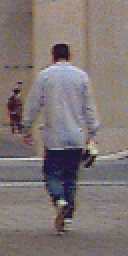

In [52]:
pos_images[1]

### Convert to Grayscale

In [25]:
#integral_img = integral_image(pos_images[1])

In [15]:
img1 = colorview(Gray, integral_img)

3×128×64 Array{Gray{Float64},3}:
[:, :, 1] =
 Gray{Float64}(0.466667)  Gray{Float64}(0.952941)  …  Gray{Float64}(63.1333)
 Gray{Float64}(0.443137)  Gray{Float64}(0.905882)     Gray{Float64}(57.6431)
 Gray{Float64}(0.443137)  Gray{Float64}(0.882353)     Gray{Float64}(54.7137)

[:, :, 2] =
 Gray{Float64}(0.952941)  Gray{Float64}(1.92549)  …  Gray{Float64}(125.816)
 Gray{Float64}(0.905882)  Gray{Float64}(1.83137)     Gray{Float64}(114.878)
 Gray{Float64}(0.803922)  Gray{Float64}(1.60392)     Gray{Float64}(109.129)

[:, :, 3] =
 Gray{Float64}(1.47451)  Gray{Float64}(2.91373)  …  Gray{Float64}(188.369)
 Gray{Float64}(1.35686)  Gray{Float64}(2.72549)     Gray{Float64}(171.702)
 Gray{Float64}(1.23922)  Gray{Float64}(2.48235)     Gray{Float64}(162.992)

...

[:, :, 62] =
 Gray{Float64}(34.4196)  Gray{Float64}(69.1569)  …  Gray{Float64}(3929.18)
 Gray{Float64}(31.5765)  Gray{Float64}(62.9647)     Gray{Float64}(3619.36)
 Gray{Float64}(29.8784)  Gray{Float64}(59.1961)     Gray{Float64}(3595.85)



In [34]:
img1 = Array{Float32}(img1);

In [63]:
img1_g = Array{Float32}(Gray.(img1))

3×128×64 Array{Float32,3}:
[:, :, 1] =
 0.466667  0.952941  1.47451  1.99608  …  61.7922  62.2549  62.7176  63.1333
 0.443137  0.905882  1.35686  1.79216     56.4275  56.8431  57.2588  57.6431
 0.443137  0.882353  1.31765  1.67059     53.6039  53.9686  54.3333  54.7137

[:, :, 2] =
 0.952941  1.92549  2.97255  4.01569  …  123.141  124.063  124.984  125.816
 0.905882  1.83137  2.76078  3.62353     112.475  113.275  114.11   114.878
 0.803922  1.60392  2.49412  3.27451     106.788  107.58   108.369  109.129

[:, :, 3] =
 1.47451  2.91373  4.44706  6.01176  …  184.357  185.737  187.075  188.369
 1.35686  2.72549  4.11765  5.40784     168.118  169.298  170.518  171.702
 1.23922  2.48235  3.81176  5.01961     159.549  160.698  161.867  162.992

...

[:, :, 62] =
 34.4196  69.1569  104.173   139.553  …  3844.89  3872.78  3900.89  3929.18
 31.5765  62.9647   94.2941  125.49      3541.76  3567.33  3593.23  3619.36
 29.8784  59.1961   88.1176  117.322     3520.53  3545.59  3570.6   3595.85

[:,

### Integral image

In [48]:
X = integral_image(img1_g[1,:,:])

128×64 Array{Float32,2}:
    0.466667      1.41961      2.89412  …   1074.01        1109.51     
    1.41961       4.29804      8.68627      3231.93        3338.89     
    2.89412       8.7451      17.5804       6486.95        6701.55     
    4.8902       14.7569      29.6039      10858.8        11217.6      
    7.40784      22.2706      44.5686      16329.9        16869.0      
   10.3922       31.1843      62.3333   …  22886.8        23642.2      
   13.8353       41.4824      82.8706      30501.9        31509.1      
   17.7373       53.1843     106.243       39192.9        40487.8      
   22.1608       66.451      132.71        48958.6        50576.9      
   27.1059       81.2823     162.271       59820.1        61798.0      
   32.5373       97.6118     194.804    …  71757.7        74130.9      
   38.4353      115.341      230.192       84755.0        87558.6      
   44.7922      134.451      268.341       98806.1            1.02075f5
    ⋮                                  

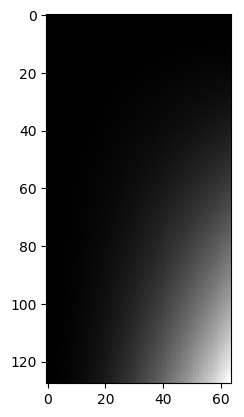

PyObject <matplotlib.image.AxesImage object at 0x13959f110>

In [49]:
using PyPlot

PyPlot.imshow(X, cmap="gray")

### From integral image to haar features

#### boxxdiff function

```
sum = boxdiff(integral_image, ytop:ybot, xtop:xbot)
sum = boxdiff(integral_image, CartesianIndex(tl_y, tl_x), CartesianIndex(br_y, br_x))
sum = boxdiff(integral_image, tl_y, tl_x, br_y, br_x)
```
An integral image is a data structure which helps in efficient calculation of sum of pixels in
a rectangular subset of an image. It stores at each pixel the sum of all pixels above it and to
its left. The sum of a window in an image can be directly calculated using four array
references of the integral image, irrespective of the size of the window, given the `yrange` and `xrange` of the window. 

Given an integral image 


        A - - - - - - B -
        - * * * * * * * -
        - * * * * * * * -
        - * * * * * * * -
        - * * * * * * * -
        - * * * * * * * -
        C * * * * * * D -
        - - - - - - - - -
The sum of pixels in the area denoted by * is given by S = D + A - B - C.


In [57]:
X[1:6,1:6]

6×6 Array{Float32,2}:
  0.466667   1.41961   2.89412    4.83529    7.24314   10.1098
  1.41961    4.29804   8.68627   14.4745    21.7176    30.3373
  2.89412    8.7451   17.5804    29.2157    43.7608    61.0588
  4.8902    14.7569   29.6039    49.1725    73.5647   102.545 
  7.40784   22.2706   44.5686    73.9765   110.58     154.059 
 10.3922    31.1843   62.3333   103.439    154.635    215.451 

In [59]:
boxdiff(X, 1:3, 1:3)

17.58039f0

In [62]:
sum(img1_g[1:3,1:3])

8.243137f0